In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [ ]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

# разделим тренировочную выборку на train и val
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# заведем даталоадеры
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


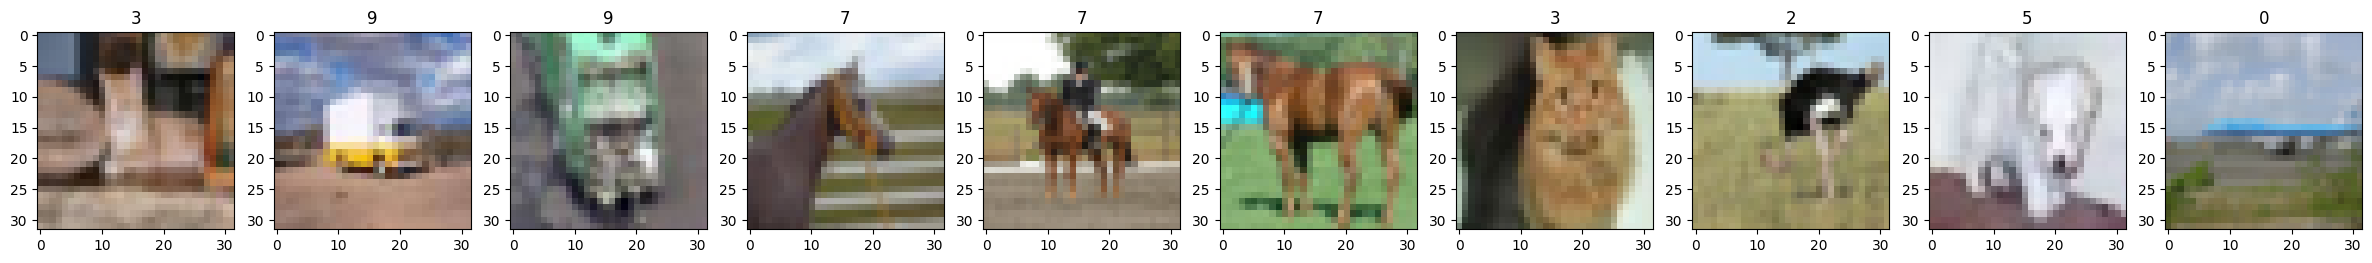

In [ ]:
# эта функция отрисовывает несколько картинок
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

# получаем батч картинок из train даталоадера
for batch in train_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

# вызываем функцию отрисовки картинок
show_images(images, labels)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm1d
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.fc_in = nn.Linear(32*32*3, 256)  # 3072 нейронов
        self.bn1 = BatchNorm1d(256)
        self.fc_hidden = nn.Linear(256, 128)
        self.bn2 = BatchNorm1d(128)
        self.fc_out = nn.Linear(128, 10)

    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя, BatchNorm, и применение функции активации
        x = F.relu(self.bn1(self.fc_in(x)))
        # умножение на матрицу весов скрытого слоя, BatchNorm, и применение функции активации
        x = F.relu(self.bn2(self.fc_hidden(x)))
        # умножение на матрицу весов 2 слоя
        x = self.fc_out(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
# объявляем модель и переносим ее на GPU
model = Model().to(device)

In [ ]:
assert model is not None, 'Переменная model пустая. Где же тогда ваша модель?'

try:
    x = images.reshape(-1, 3072).to(device)
    y = labels

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('С моделью что-то не так')
    raise e


assert y_predicted.shape[-1] == 10, 'В последнем слое модели неверное количество нейронов'

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn):

    y_pred_list = []
    y_true_list = []
    losses = []

    # проходимся по батчам даталоадера
    for i, batch in enumerate(tqdm(dataloader)):

        # так получаем текущий батч
        X_batch, y_batch = batch

        # выключаем подсчет любых градиентов
        with torch.no_grad():

            # получаем ответы сети на батч
            logits = model(X_batch.to(device))

            # вычисляем значение лосс-функции на батче
            loss = loss_fn(logits, y_batch.to(device))
            loss = loss.item()

            # сохраняем лосс на текущем батче в массив
            losses.append(loss)

            # для каждого элемента батча понимаем,
            # к какому классу от 0 до 9 отнесла его сеть
            y_pred = torch.argmax(logits, dim=1)

        # сохраняем в массивы правильные ответы на текущий батч
        # и ответы сети на текущий батч
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())

    # считаем accuracy между ответам сети и правильными ответами
    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

In [ ]:
def train(model, loss_fn, optimizer, n_epoch=6):

    model.train(True)

    data = {
        'acc_train': [],
        'loss_train': [],
        'acc_val': [],
        'loss_val': []
    }

    # цикл обучения сети
    for epoch in tqdm(range(n_epoch)):

        for i, batch in enumerate(tqdm(train_loader)):

            # так получаем текущий батч картинок и ответов к ним
            X_batch, y_batch = batch

            # forward pass (получение ответов сети на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))

            optimizer.zero_grad() # обнуляем значения градиентов оптимизаторв
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети

        # конец эпохи, валидируем модель
        print('On epoch end', epoch)

        acc_train_epoch, loss_train_epoch = evaluate(model, train_loader, loss_fn)
        print('Train acc:', acc_train_epoch, 'Train loss:', loss_train_epoch)

        acc_val_epoch, loss_val_epoch = evaluate(model, val_loader, loss_fn)
        print('Val acc:', acc_val_epoch, 'Val loss:', loss_val_epoch)


        data['acc_train'].append(acc_train_epoch)
        data['loss_train'].append(loss_train_epoch)
        data['acc_val'].append(acc_val_epoch)
        data['loss_val'].append(loss_val_epoch)

    return model, data

In [ ]:
# объявляем модель и переносим ее на GPU
model = Model().to(device)

# функция потерь
loss_fn = torch.nn.CrossEntropyLoss()

# оптимизатор
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model, data = train(model, loss_fn, optimizer, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 0


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.4834 Train loss: 1.4554664457321167


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4505 Val loss: 1.5475327171337832


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 1


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.53815 Train loss: 1.3042348342895507


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.482 Val loss: 1.4442736715268178


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 2


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.566475 Train loss: 1.2283728945732117


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4956 Val loss: 1.419182712105429


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 3


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.591125 Train loss: 1.151881864452362


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5055 Val loss: 1.3971296658941135


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 4


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.6213 Train loss: 1.0755812052726745


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5139 Val loss: 1.3783697952890093


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 5


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.6323 Train loss: 1.0429273713111877


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5147 Val loss: 1.3969535193625529


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 6


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.654525 Train loss: 0.9749096276283264


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5177 Val loss: 1.394592404745187


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 7


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.678325 Train loss: 0.9105785445213318


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5202 Val loss: 1.3974937659919642


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 8


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.691575 Train loss: 0.8743788011550904


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.521 Val loss: 1.4225692118808722


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 9


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.71705 Train loss: 0.8053807796478272


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5284 Val loss: 1.414717048976072


In [ ]:
test_acc, test_loss = evaluate(model, test_loader, loss_fn)

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
test_acc

0.5369

In [ ]:
assert test_acc >= 0.5, 'Accuracy на тесте >0.5! Можно сдавать задание'

In [ ]:
x = torch.randn((64, 32*32*3))
torch.jit.save(torch.jit.trace(model.cpu(), (x)), "model.pth")